In [1]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal


%config InlineBackend.figure_format = 'retina'


In [2]:
ADJ_PATH = '/home/udit/Documents/Progyan/results_new_95/Year_{}.npy'
COORD_PATH = '/home/udit/Documents/Progyan/Lat_lon/lat_lon-{}.csv'

In [3]:
graph_list = []

for year in tqdm(range(2003, 2016)):
    if year == 2005 or year == 2012:
        continue
    i = year
    adj_matrix = np.load(ADJ_PATH.format(i))
    lat_lon_df = pd.read_csv(COORD_PATH.format(i))

    adj_matrix = adj_matrix + adj_matrix.transpose()

    ##### REMOVE ######
    adj_matrix = adj_matrix[:4523, :4523]
    ###################

    adj_matrix[adj_matrix < 0.3] = 0
    np.fill_diagonal(adj_matrix, 0)
    G = nx.from_numpy_matrix(adj_matrix)

    lat_lon_dict = {}
    for i in range(len(lat_lon_df)):
        lat_lon_dict[i] = [lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'], lat_lon_df.loc[i, 'rain']]

    nx.set_node_attributes(G, lat_lon_dict, 'pos')
    pos = nx.get_node_attributes(G, 'pos')

    central_nodes = []

    for n in G.nodes:
        if G.nodes[n]['pos'][0] > 74.5 and G.nodes[n]['pos'][0] < 86.5 and G.nodes[n]['pos'][1] > 16.5 and G.nodes[n]['pos'][1] < 26.5:
            central_nodes.append(n)

    G = G.subgraph(central_nodes)

    graph_list.append(G)

100%|██████████| 13/13 [01:01<00:00,  4.75s/it]


In [ ]:
india_pos

EdgeView([(674, 681), (674, 683), (674, 711), (674, 748), (674, 753), (674, 777), (674, 787), (674, 789), (674, 794), (674, 827), (674, 829), (674, 830), (674, 870), (674, 871), (674, 872), (674, 913), (674, 914), (674, 915), (674, 916), (674, 960), (674, 966), (674, 1188), (675, 676), (675, 677), (675, 679), (675, 681), (675, 688), (675, 689), (675, 712), (675, 713), (675, 714), (675, 715), (675, 716), (675, 721), (675, 724), (675, 728), (675, 748), (675, 749), (675, 750), (675, 751), (675, 752), (675, 753), (675, 765), (675, 777), (675, 787), (675, 791), (675, 796), (675, 797), (675, 803), (675, 804), (675, 812), (675, 813), (675, 828), (675, 829), (675, 830), (675, 833), (675, 834), (675, 835), (675, 844), (675, 845), (675, 846), (675, 852), (675, 858), (675, 869), (675, 870), (675, 871), (675, 872), (675, 882), (675, 887), (675, 890), (675, 913), (675, 914), (675, 915), (675, 923), (675, 933), (675, 944), (675, 958), (675, 966), (675, 967), (675, 972), (675, 1014), (675, 1015), (67

0it [00:00, ?it/s]/tmp/ipykernel_1084/329530837.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')
/tmp/ipykernel_1084/329530837.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_edge = plt.cm.get_cmap('tab20')
0it [00:06, ?it/s]


ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (2, 3).

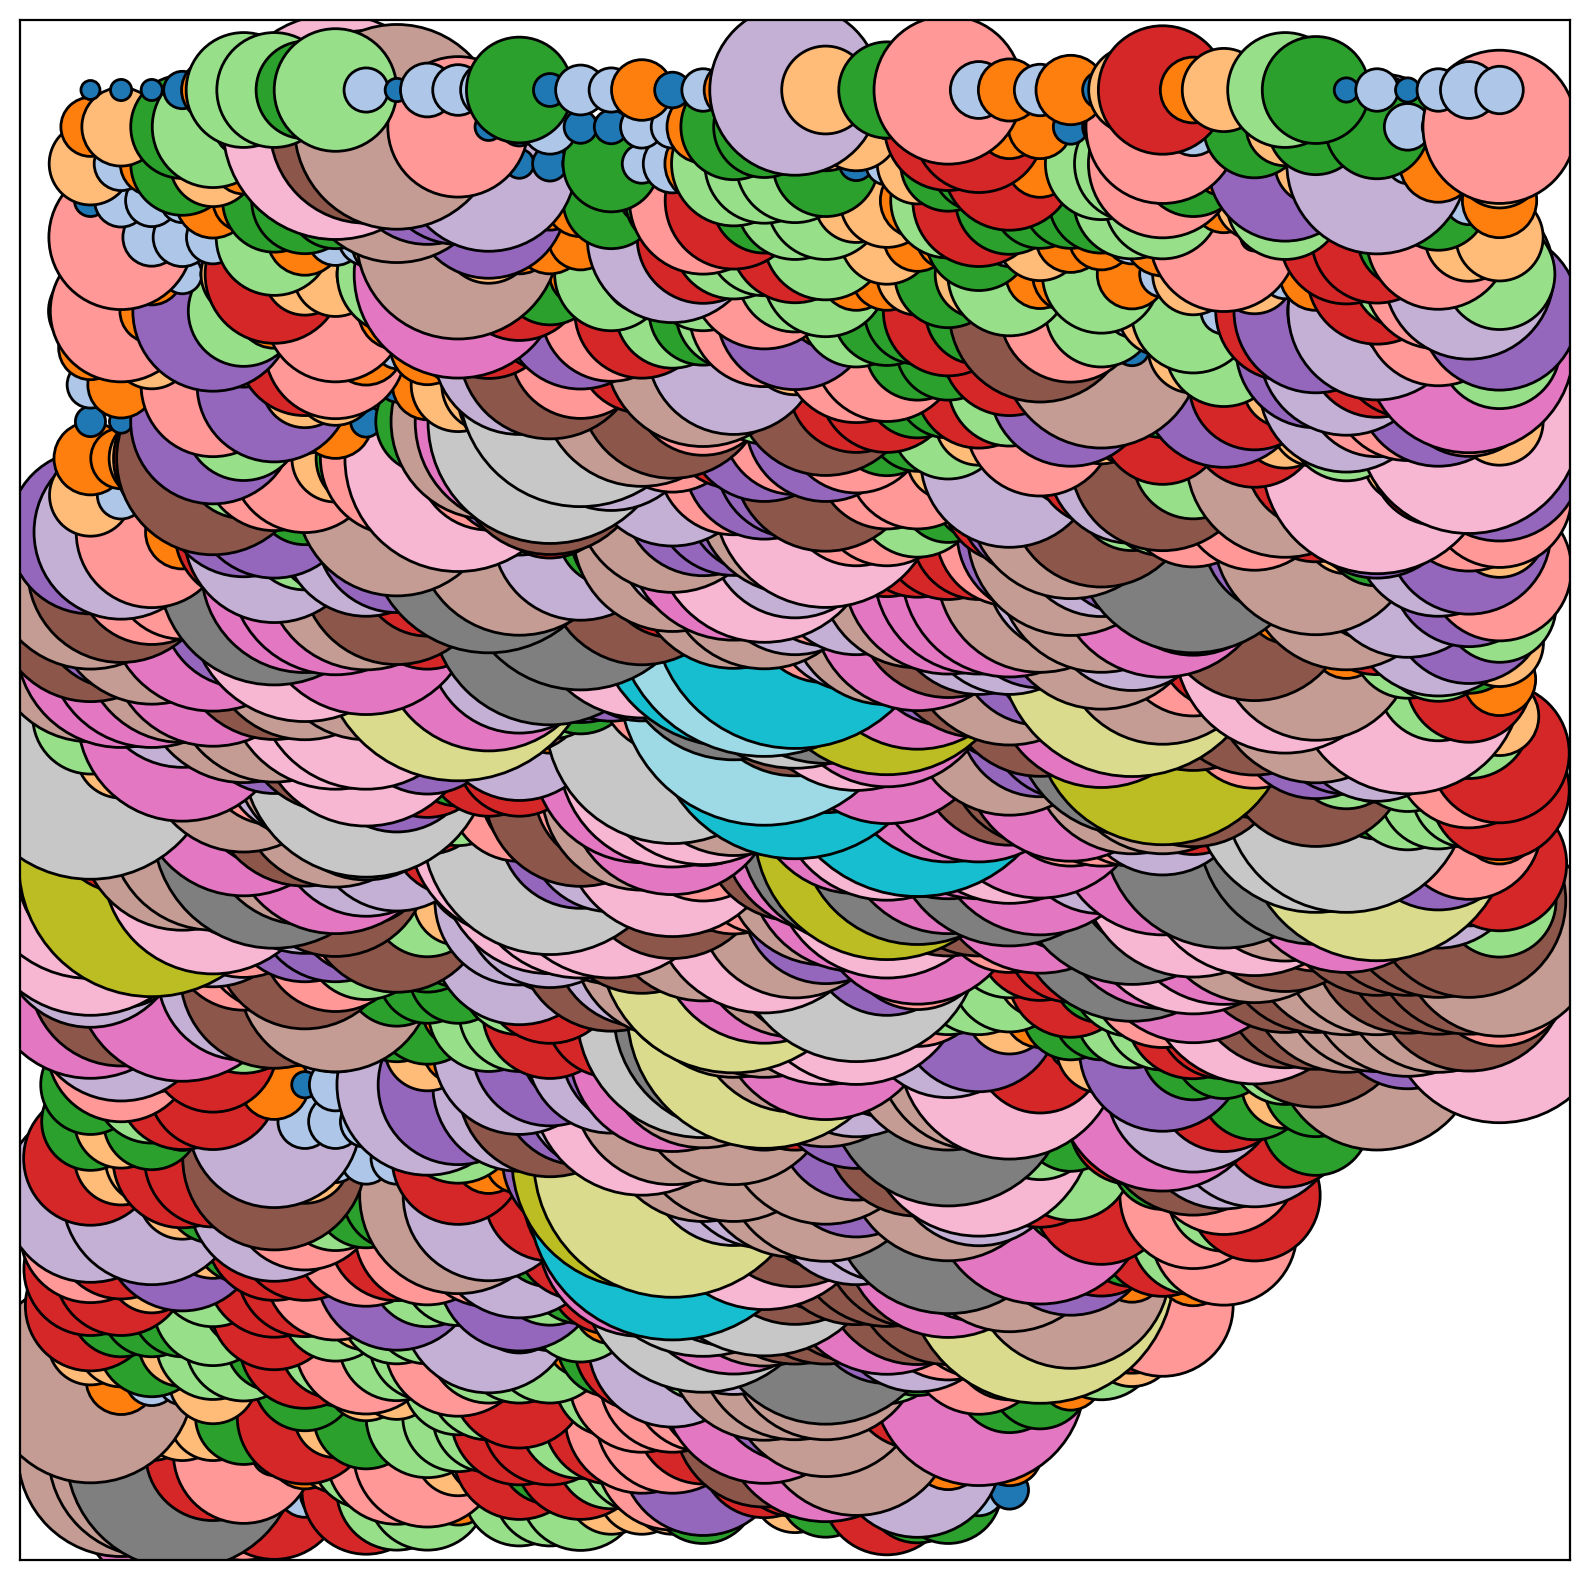

In [4]:
for _, G in tqdm(enumerate(graph_list)):        
    plot = plt.figure(figsize=(10,10))
    india_coords = [[74.5, 86.5], [16.5, 26.5]]
    india_pos = {}

    for node_id, coords in pos.items():
        if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
            india_pos[node_id] = coords

    d = dict(G.degree)
    degree_dict = dict(G.degree()) 
    degree_values = np.array(list(degree_dict.values())) 

    cmap = plt.cm.get_cmap('tab20')
    cmap_edge = plt.cm.get_cmap('tab20')

    normalized_degrees = (degree_values - degree_values.min()) / (degree_values.max() - degree_values.min())

    node_colors = cmap(normalized_degrees)

    edge_widths = [d['weight'] for (u, v, d) in G.edges(data=True)]
    edge_colors = [d['weight']**3 for (u, v, d) in G.edges(data=True)]

    edge_colors = cmap_edge(edge_colors)

    ################# PLOT NETWORK #####################
    nx.draw_networkx(G, pos = india_pos,
            nodelist=d, 
            width=edge_widths,
            edge_color=edge_colors,
            edgecolors = 'black',
            node_size=[(d[k])**1.5 for k in d],
            with_labels = False,
            node_color=node_colors,)
            
    # img = plt.imread('/home/udit/Documents/Progyan/GNN/physical-map-in    dia.jpg')
    # plt.imshow(img, extent=[68, 96.5, 5.5, 36.5], alpha=1)
    ######################################################

    save = plt.savefig(f'./temporal_train_graphs/graph{_}.png')

In [5]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [6]:
device = "cuda:0"

In [7]:
lat_lon_df

lat    lon       rain
0      8.25  77.00  41.336472
1      8.25  77.25  43.416500
2      8.25  77.50  38.923370
3      8.25  77.75  41.172775
4      8.50  76.75  42.607677
...     ...    ...        ...
4863  37.00  75.50  29.855500
4864  37.25  74.50  19.277391
4865  37.25  74.75  23.651925
4866  37.25  75.00  28.671249
4867  37.25  75.25  29.375990

[4868 rows x 3 columns]

In [8]:
lat_lon_df = lat_lon_df.iloc[central_nodes]

list_node_features = []
list_edge_list = []
list_target_features = []
list_edge_weights = []

list_node_features_cpu = []
list_edge_list_cpu = []
list_target_features_cpu = []
list_edge_weights_cpu = []

j = 0

for i, graph in tqdm(enumerate(graph_list[:-1])):
    
    j = 2003 + i 
    if j == 2005 or j == 2012:
        j += 1

    adj_matrix = nx.to_numpy_matrix(graph)
    lat_lon_df = pd.read_csv(COORD_PATH.format(j))

    node_features = []
    target_features = []
    for i in lat_lon_df.index:
        node_features.append([lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'], lat_lon_df.loc[i, 'rain']])
        target_features.append([lat_lon_df.loc[i, 'rain']])
    node_features = torch.tensor(node_features, dtype=torch.float)


    edge_list = set()
    edge_weights = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] > 0:
                append_edge = frozenset({i, j})
                edge_list.add(append_edge)
    edge_list = [tuple(x) for x in list(edge_list)]


    for x,y in edge_list:
        edge_weights.append(adj_matrix[x, y])

    edge_list = np.array(edge_list)
    edge_weights = np.array(edge_weights)
    edge_list = edge_list.transpose()

    central_pos = {}
    for _, i in enumerate(central_nodes):
        central_pos[_] = pos[i]

    transform = ToUndirected()

    list_node_features_cpu.append(np.array(node_features))
    list_edge_list_cpu.append(edge_list)
    list_target_features_cpu.append(np.array(node_features[:, 2]))
    list_edge_weights_cpu.append(edge_weights)

    list_node_features.append((node_features).to(device))
    list_edge_list.append((torch.from_numpy(edge_list)).to(device))
    list_target_features.append(node_features[:, 2].to(device))
    list_edge_weights.append(torch.tensor(edge_weights).to(device))

node_features_batch = (list_node_features)
edge_list_batch = (list_edge_list)
target_features_batch = (list_target_features)
edge_weights_batch = (list_edge_weights)

node_features_batch_cpu = list_node_features_cpu
edge_list_batch_cpu = list_edge_list_cpu
target_features_batch_cpu = list_target_features_cpu
edge_weights_batch_cpu = list_edge_weights_cpu



10it [02:04, 12.43s/it]


In [9]:
# np.roll(target_features_batch_cpu, 1)
target_features_batch_cpu = np.roll(target_features_batch_cpu, -1, axis = 0)
target_features_batch = target_features_batch[1:].append(target_features_batch[0])

In [29]:
target_features_batch = torch.from_numpy(target_features_batch_cpu)

In [30]:
dataset = DynamicGraphTemporalSignal(edge_indices= edge_list_batch, edge_weights=edge_weights_batch, features=node_features_batch, targets=target_features_batch)

dataset_cpu = DynamicGraphTemporalSignal(edge_indices= edge_list_batch_cpu, edge_weights=edge_weights_batch_cpu, features=node_features_batch_cpu, targets=target_features_batch_cpu)

In [31]:
# class RecurrentGCN(torch.nn.Module):
#     def __init__(self, node_features):
#         super(RecurrentGCN, self).__init__()
#         self.recurrent = DCRNN(node_features, 32, 1)
#         self.linear = torch.nn.Linear(32, 1)

#     def forward(self, x, edge_index, edge_weight):
#         h = self.recurrent(x, edge_index, edge_weight)
#         h = F.relu(h)
#         h = self.linear(h)
#         return h

In [48]:
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.dropout = torch.nn.Dropout(0.4).to(device)
        self.linear = torch.nn.Linear(dim_in, 2)
        self.linear_2 = torch.nn.Linear(2, 1)
    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h)
        h = self.linear_2(h)
        return h

In [49]:
model = TemporalGNN(dataset_cpu[0].x.shape[0], dataset_cpu[0].x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

TemporalGNN(
  (recurrent): EvolveGCNH(
    (pooling_layer): TopKPooling(3, ratio=0.0006162695152013147, multiplier=1.0)
    (recurrent_layer): GRU(3, 3)
    (conv_layer): GCNConv_Fixed_W(3, 3)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=3, out_features=2, bias=True)
  (linear_2): Linear(in_features=2, out_features=1, bias=True)
)

In [50]:
# from torch_geometric_temporal.nn.recurrent import MPNNLSTM


# class TemporalGNN(torch.nn.Module):
#     def __init__(self, dim_in, dim_h, num_nodes):
#         super().__init__()
#         self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5).to(device)
#         self.dropout = torch.nn.Dropout(0.2).to(device)
#         self.linear = torch.nn.Linear(2*dim_h + dim_in, 1).to(device)
#         self.linear_2 = torch.nn.Linear(200, 1)
#         self.linear_3 = torch.nn.Linear(100, 50)
#         self.linear_4 = torch.nn.Linear(50, 1) 

#     def forward(self, x, edge_index, edge_weight):
#         h = self.recurrent(x, edge_index, edge_weight).relu()
#         h = self.dropout(h)
#         h = self.linear(h).relu()
#         # # h = self.linear_2(h).relu()
#         # h = self.linear_3(h).relu()
#         # h = self.linear_4(h).relu()
#         return h

# model = TemporalGNN(dataset_cpu[0].x.shape[1], 128, dataset_cpu[0].x.shape[0])
# print(model)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model.train()


In [51]:
train_dataset, test_dataset = temporal_signal_split(dataset_cpu, train_ratio=0.8)

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_dataset.targets.reshape(-1, 1))
targets_scaled = []
for _ in train_dataset.targets:
    targets_scaled.append(scaler.transform(_.reshape(-1,1)).reshape(-1,))


In [53]:
train_dataset.targets = np.array(targets_scaled)

In [54]:
test_scaled = []
for _ in test_dataset.targets:
    test_scaled.append(scaler.transform(_.reshape(-1,1)).reshape(-1,))

In [55]:
test_dataset.targets = np.array(test_scaled)

In [56]:
model = model.to("cuda:0")

In [57]:
model.train()

TemporalGNN(
  (recurrent): EvolveGCNH(
    (pooling_layer): TopKPooling(3, ratio=0.0006162695152013147, multiplier=1.0)
    (recurrent_layer): GRU(3, 3)
    (conv_layer): GCNConv_Fixed_W(3, 3)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=3, out_features=2, bias=True)
  (linear_2): Linear(in_features=2, out_features=1, bias=True)
)

In [59]:
optimizer.lr = 0.001

In [60]:
import torch.nn as nn
criterion = nn.MSELoss()

In [91]:
model.train()
for epoch in (range(500)):
    loss = 0
    print(epoch, end = "\r")
    for i, snapshot in enumerate(train_dataset):
        snapshot = snapshot.cuda()
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean(criterion(y_pred, snapshot.y))
    loss = loss / (i+1)
    print(loss, epoch, end = "\r")
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([4868])) that is different to the input size (torch.Size([4868, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



KeyboardInterrupt: 

In [92]:
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    snapshot = snapshot.to(device)
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean(torch.tensor((scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))-scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)))**2).sqrt())
    loss += mse
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

MSE: 31.2925


In [93]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot

# Create two numpy arrays with some sample data
x = np.linspace(0, 5000, 4868)
y1 = (snapshot.y.detach().cpu().reshape(-1,))
y2 = (y_pred.detach().cpu().reshape(-1,)) + 0.1

# Create the traces for each line
trace1 = go.Scatter(x=x, y=y1, mode='lines', name='true')
trace2 = go.Scatter(x=x, y=y2, mode='lines', name='pred')

# Create the layout for the plot
layout = go.Layout(title='Plot')

# Create the figure object and add the traces and layout
fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)

# Show the plot


In [97]:
nx.draw_networkx(G)

KeyboardInterrupt: 

In [103]:
torch.tensor(list(G.edges)).shape

torch.Size([123122, 2])

In [110]:
d

{674: 35,
 675: 65,
 676: 46,
 677: 65,
 678: 65,
 679: 52,
 680: 29,
 681: 84,
 682: 187,
 683: 116,
 684: 61,
 685: 19,
 686: 31,
 687: 32,
 688: 15,
 689: 70,
 690: 37,
 691: 83,
 692: 57,
 693: 30,
 694: 56,
 695: 41,
 696: 41,
 697: 101,
 698: 101,
 699: 59,
 700: 82,
 701: 136,
 702: 60,
 703: 38,
 704: 38,
 711: 32,
 712: 35,
 713: 46,
 714: 72,
 715: 68,
 716: 105,
 717: 72,
 718: 102,
 719: 47,
 720: 57,
 721: 186,
 722: 169,
 723: 64,
 724: 63,
 725: 109,
 726: 268,
 727: 19,
 728: 41,
 729: 42,
 730: 19,
 731: 17,
 732: 56,
 733: 86,
 734: 86,
 735: 90,
 736: 102,
 737: 15,
 738: 166,
 739: 83,
 740: 70,
 741: 83,
 748: 25,
 749: 70,
 750: 73,
 751: 32,
 752: 43,
 753: 34,
 754: 88,
 755: 129,
 756: 129,
 757: 118,
 758: 23,
 759: 206,
 760: 150,
 761: 187,
 762: 103,
 763: 327,
 764: 68,
 765: 20,
 766: 38,
 767: 19,
 768: 129,
 769: 101,
 770: 112,
 771: 43,
 772: 54,
 773: 56,
 774: 98,
 775: 72,
 776: 86,
 777: 49,
 778: 58,
 779: 104,
 787: 69,
 788: 70,
 789: 42,
 790:

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (2, 3).

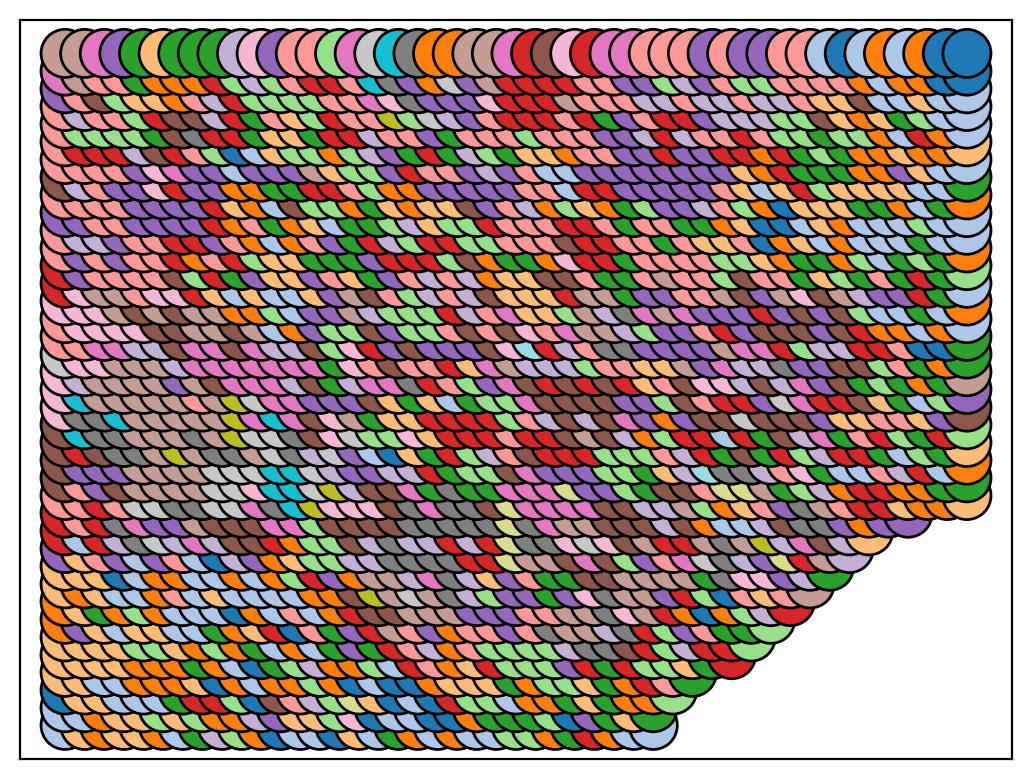

In [111]:
nx.draw_networkx(G, pos = india_pos,
            # nodelist=d, 
            width=edge_widths,
            edge_color=edge_colors,
            edgecolors = 'black',
            # node_size=[(d[k])*1.5 for k in d],
            with_labels = False,
            node_color=node_colors,)

In [ ]:
y_pred

tensor([[-0.0616],
        [-0.0546],
        [-0.0285],
        ...,
        [-0.0676],
        [-0.0626],
        [-0.0580]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [195]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [196]:
import seaborn as sns

In [198]:
sns.set()

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

In [220]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

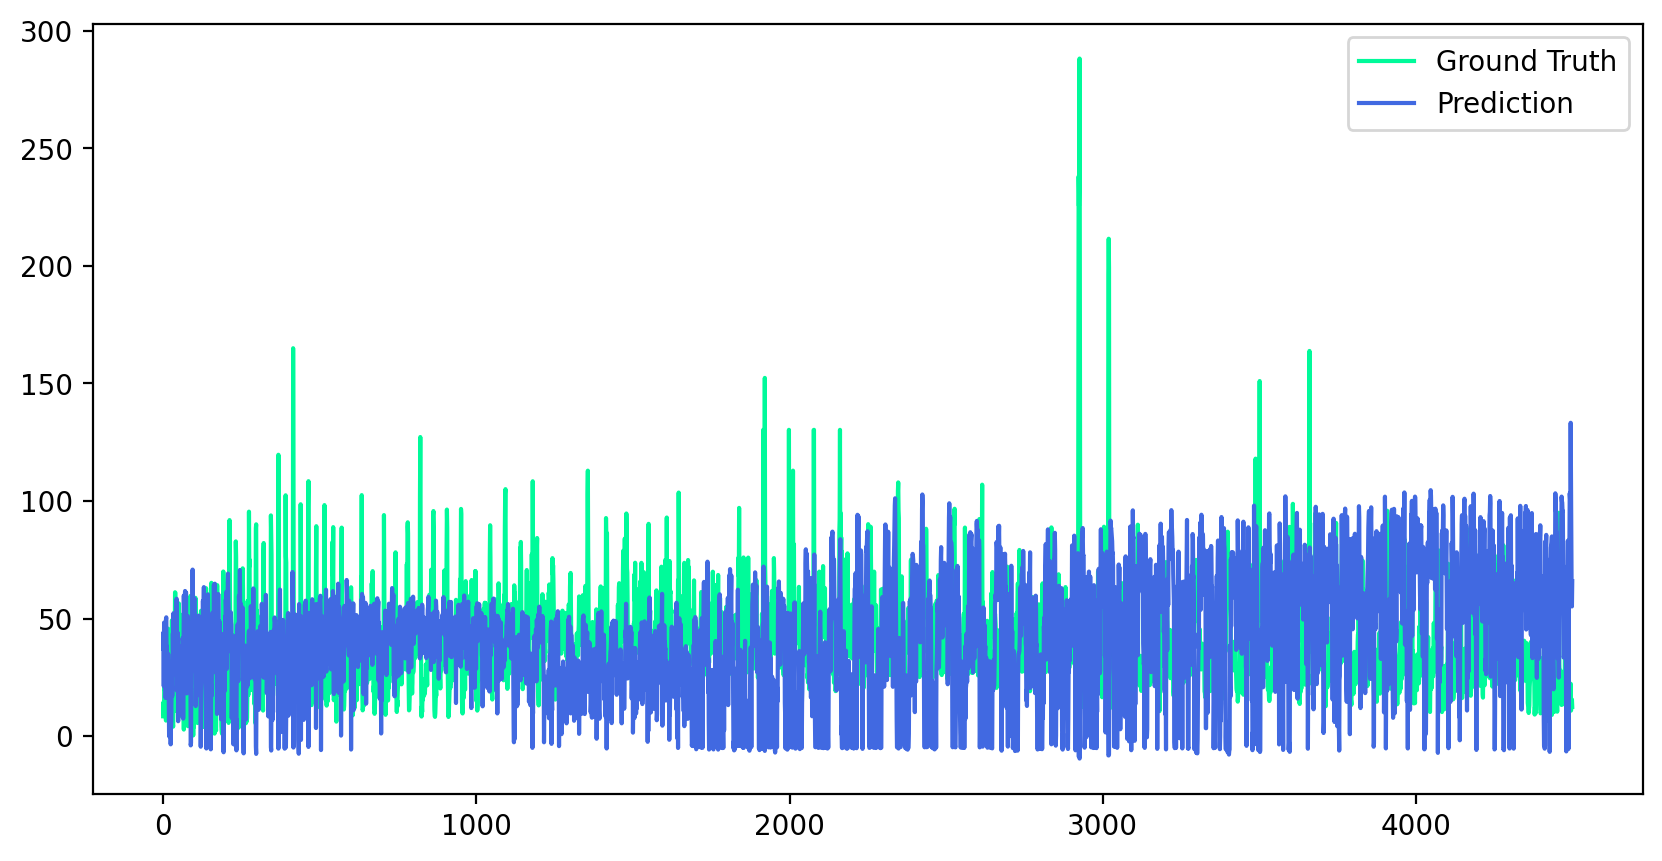

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "mediumspringgreen")
plt.plot(scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))[:4500, :] + 15, label = "Prediction", color = "royalblue")
plt.legend()

In [214]:
from sklearn.metrics import mean_squared_error
mean_squared_error(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)), scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1)))**0.5

36.61090753540802